In [3]:
# 필요 패키지 설치
!pip install mysql-connector-python
!pip install statsmodels
!pip install matplotlib scikit-learn
!pip install seaborn
!pip install matplotlib
# !pip install tensorflow-gpu==1.12

     |████████████████████████████████| 14.7MB 48.3MB/s eta 0:00:01   |██████▍                         | 2.9MB 252kB/s eta 0:00:47
     |████████████████████████████████| 194kB 31.1MB/s eta 0:00:01
     |████████████████████████████████| 1.1MB 29.7MB/s eta 0:00:01
  Found existing installation: protobuf 3.7.1
    Uninstalling protobuf-3.7.1:
      Successfully uninstalled protobuf-3.7.1
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 8.7MB 6.2MB/s eta 0:00:01     |█▏                              | 307kB 286kB/s eta 0:00:30     |█████████████████████████       | 6.8MB 4.7MB/s eta 0:00:01
     |████████████████████████████████| 235kB 8.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip insta

In [4]:
from get_sdams_db import GetSdamsDB
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
# from keras import *
# from keras.layers import *
import keras
# import imblearn
import random
import numpy as np
from datetime import date, datetime, timedelta
import tensorflow as tf
from tensorflow.contrib.keras import *
# from tensorflow.contrib.keras.layers import Dense

Using TensorFlow backend.


In [5]:
def seq2dataset(df, look_back): # Sliding window 함수
    dataset=[]
    for i in range(len(df) - (look_back+90)):
#         subset = df[i:i+look_back+1]['PD_MAX']
        subset = df[i:i+(look_back+90)]
        dataset.append(subset)
    return np.array(dataset)

# 1. 데이터 불러오기

In [6]:
sql = " SELECT MESR_DAY, PD_MAX_95 AS PD_MAX "+\
      " FROM ml_pd.TRAIN_PD_EQP_DGDGR_DTLS_ORIG WHERE EQP_SERNO = 14 " # SERIAL NO 14 = 죽동 T1

with GetSdamsDB() as dbCon:
    orig_df = dbCon.getDataPD(sql)    

InterfaceError: 2003: Can't connect to MySQL server on '125.133.65.253:3306' (113 No route to host)

In [4]:
orig_df

,MESR_DAY,PD_MAX
0,2019-07-10,32.00
1,2019-07-11,47.00
2,2019-07-12,47.00
3,2019-07-13,45.00
4,2019-07-15,47.00
5,2019-07-17,45.00
6,2019-07-18,46.00
7,2019-07-19,46.00
8,2019-07-20,46.00
9,2019-07-22,47.00


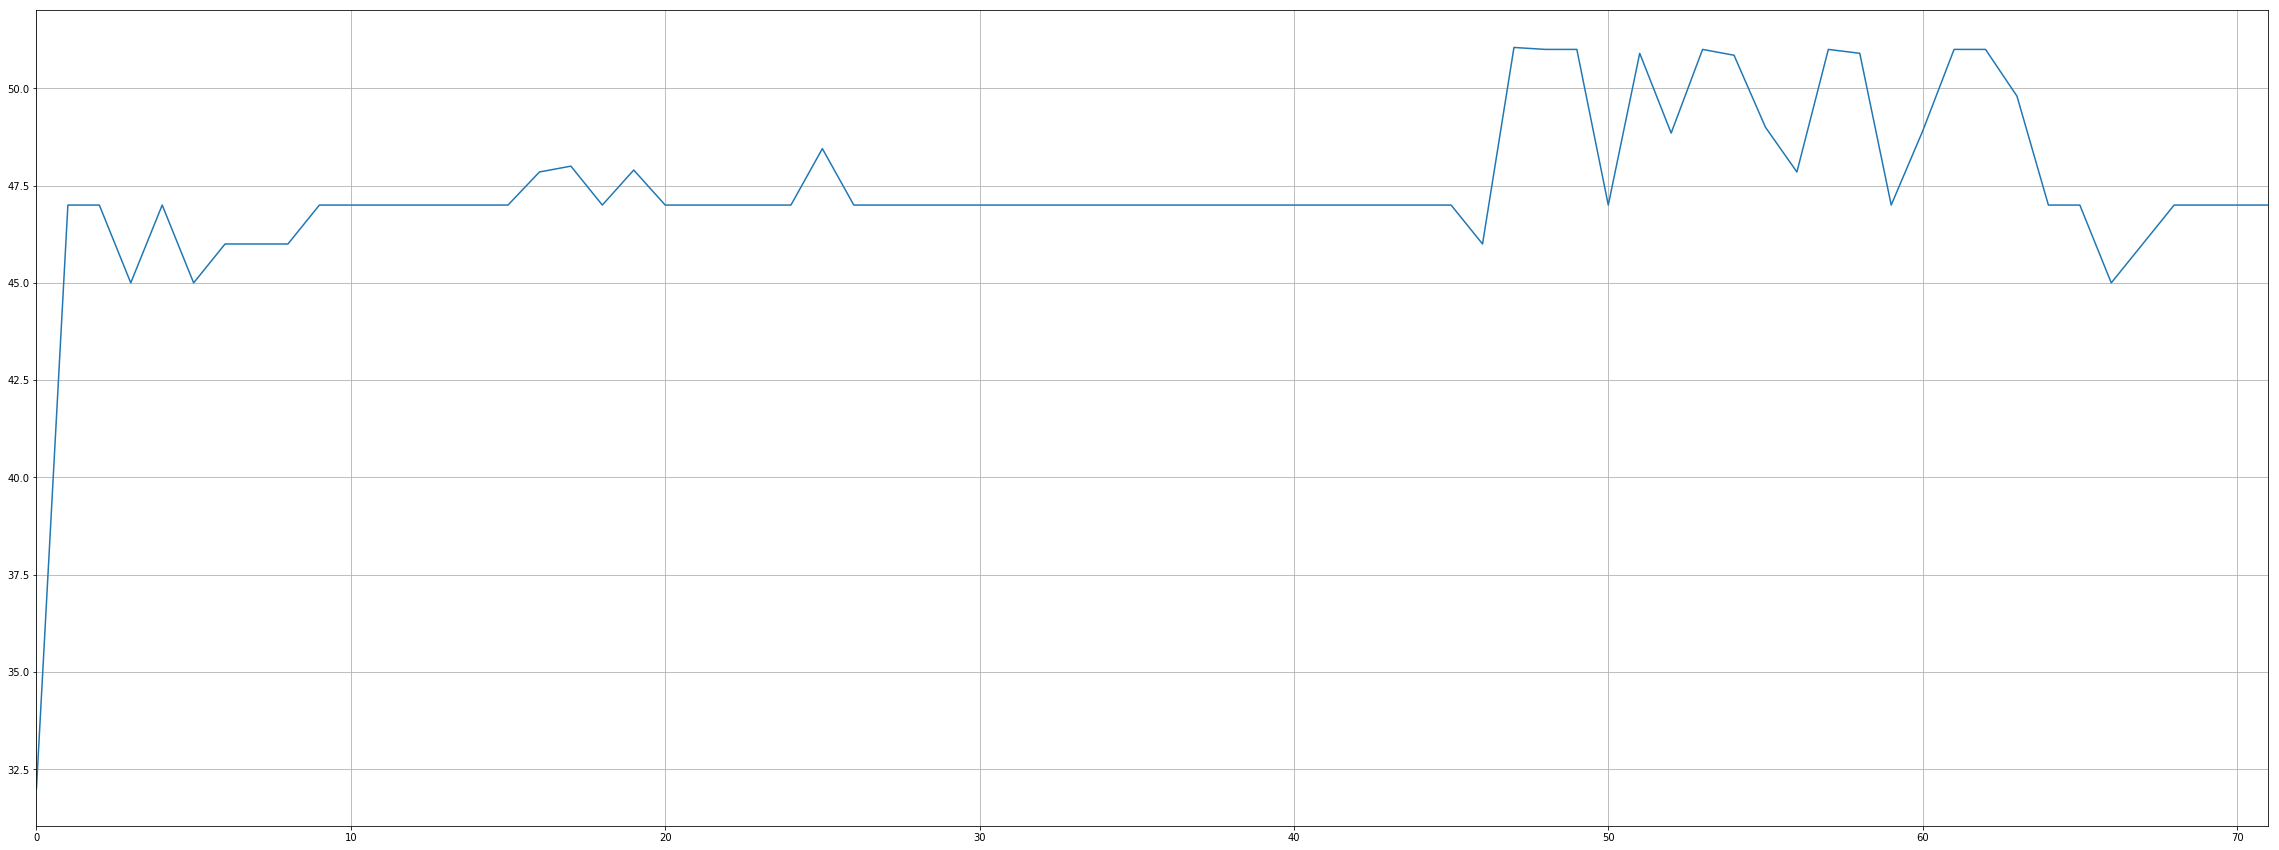

In [4]:
# 시각화를 통해 변화추이 확인
plt.figure(figsize=(40,15))
# sns.lineplot(x= orig_df['MESR_DAY'], y=orig_df['PD_MAX'])
orig_df['PD_MAX'].plot()
plt.grid()

# 2. Smote 알고리즘을 변형하여 Synthetic data 생성

In [5]:
def Smote(orig_df, n_nearest_neighbor=5):
    synthetic_data=[]
    for i in range(len(orig_df)):
        origin = orig_df[i]
        nearest_idx= {}
        except_myself = list(range(len(orig_df)))
        except_myself.remove(i) 
        for j in except_myself: #자신을 제외한 모든 sample index에 대해 for loop
            nearest_idx[abs(origin - orig_df[j])] = j   #자신과 다른 샘플의 차이값을 키로, 샘플 인덱스를 밸류로
        sorted_values = list(nearest_idx)
        sorted_values.sort()    #키를 기준으로 정렬
        nn = sorted_values[:n_nearest_neighbor]   #가까운 이웃 n개 가져오기
        chosen_value = np.random.choice(nn, size=1)   #랜덤하게 하나 선택
#         chosen_idx = nearest_idx[chosen_value[0]]   #??
        synthetic_value = origin + chosen_value * np.random.rand()   #차이값에 0 ~ 1 를 곱해 중간값 생성 + 원본값
        synthetic_data.append(synthetic_value)
    return np.asarray(synthetic_data).reshape((-1,))

In [6]:
def Smote_generator(orig, res_samples):
    n_orig = orig.shape[0]
    n_iter = (res_samples - n_orig)//n_orig
    residual = (res_samples - n_orig)%n_orig
    
    for i in range(n_iter):
        res = Smote(orig[-n_orig : ])
        res_ = res + np.random.rand(res.shape[0])*1.7 #증가하는 경향을 만들기 위해 1.7 곱함
#         np.random.shuffle(res_)
        orig = np.concatenate([orig, res_])
    
    res = Smote(orig[-residual: ])
    res_ = res + np.random.rand(res.shape[0])*1.7
#     np.random.shuffle(res_)
    orig = np.concatenate([orig, res_])
    
    return orig

In [7]:
# SMOTE 를 통해 인조데이터 1년치 생성
orig = np.asarray(orig_df['PD_MAX'][2:])
orig = Smote_generator(orig, res_samples=365) 

In [21]:
pd.date_range('2019-07-10', periods=365).to_pydatetime().tolist()

[datetime.datetime(2019, 7, 10, 0, 0),
 datetime.datetime(2019, 7, 11, 0, 0),
 datetime.datetime(2019, 7, 12, 0, 0),
 datetime.datetime(2019, 7, 13, 0, 0),
 datetime.datetime(2019, 7, 14, 0, 0),
 datetime.datetime(2019, 7, 15, 0, 0),
 datetime.datetime(2019, 7, 16, 0, 0),
 datetime.datetime(2019, 7, 17, 0, 0),
 datetime.datetime(2019, 7, 18, 0, 0),
 datetime.datetime(2019, 7, 19, 0, 0),
 datetime.datetime(2019, 7, 20, 0, 0),
 datetime.datetime(2019, 7, 21, 0, 0),
 datetime.datetime(2019, 7, 22, 0, 0),
 datetime.datetime(2019, 7, 23, 0, 0),
 datetime.datetime(2019, 7, 24, 0, 0),
 datetime.datetime(2019, 7, 25, 0, 0),
 datetime.datetime(2019, 7, 26, 0, 0),
 datetime.datetime(2019, 7, 27, 0, 0),
 datetime.datetime(2019, 7, 28, 0, 0),
 datetime.datetime(2019, 7, 29, 0, 0),
 datetime.datetime(2019, 7, 30, 0, 0),
 datetime.datetime(2019, 7, 31, 0, 0),
 datetime.datetime(2019, 8, 1, 0, 0),
 datetime.datetime(2019, 8, 2, 0, 0),
 datetime.datetime(2019, 8, 3, 0, 0),
 datetime.datetime(2019, 8, 

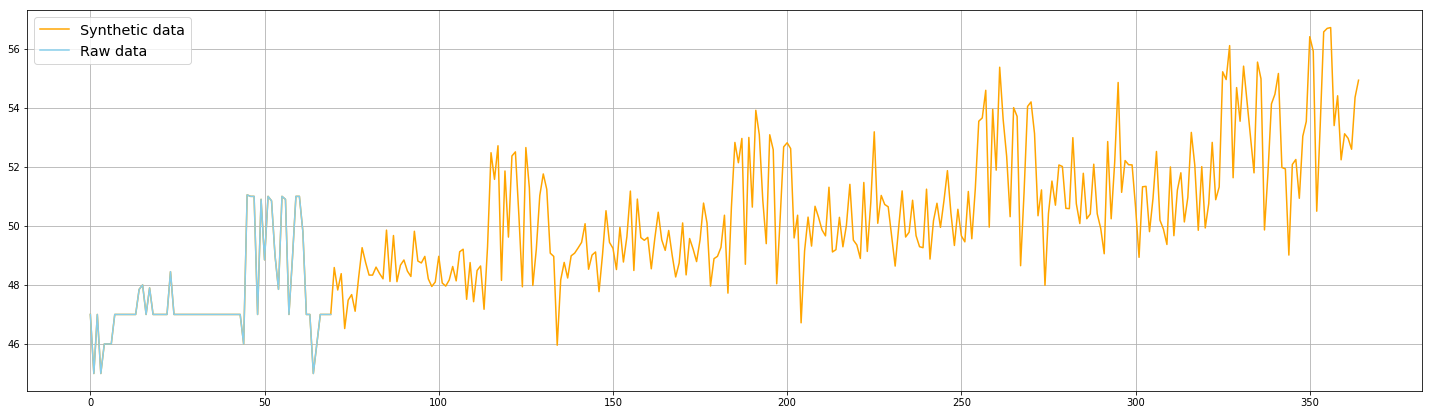

In [9]:
# SMOTE 생성결과
plt.figure(figsize=(25,7))
pd.Series(orig).plot(color='orange', label='Synthetic data')
orig_df['PD_MAX'][2:].reset_index(drop=True).plot(color='skyblue', label = 'Raw data')
plt.grid()
plt.legend(fontsize='x-large')

----------

### SMOTE 인조데이터 DB에 저장(optional) 

In [16]:
orig_smote = pd.DataFrame({'PD_ID': list(range(365)), 'MESR_DAY': pd.date_range(start='2019-07-12', periods=365, freq='D'), 'EQP_SERNO' : 14, 'PD_MAX_95' : orig })

In [19]:
orig_smote.iloc[0]['PD_MAX_95'].item() # .item() 은 python nature 형으로 변환해준다 ex) np.float64 -> float

47.0

In [17]:
orig_smote['MESR_DAY'] = orig_smote['MESR_DAY'].astype(str)
orig_smote['PD_MAX_95'] = orig_smote['PD_MAX_95'].apply(lambda x : round(x,3))

In [20]:
### insert to train_pd_dgdgr_dtls_gen
sql = """ INSERT INTO ml_pd.TRAIN_PD_DGDGR_DTLS_GEN (PD_ID, MESR_DAY, PD_MAX_95)
        VALUES (%(PD_ID)s, %(MESR_DAY)s, %(PD_MAX_95)s) """

with GetSdamsDB() as dbCon:   
    for i in range(orig_smote.shape[0]):
        dbCon.cursor.execute(sql, 
                             {'PD_ID' : i+1, 
                              'MESR_DAY' : orig_smote.iloc[i]['MESR_DAY'], 
                              'PD_MAX_95': orig_smote.iloc[i]['PD_MAX_95'].item()}
#                                 {'PD_ID' : 574, 'MESR_DAY' : '2019-12-24', 'EQP_SERNO' :14, 'PD_MAX_95': 60.0}
                                )
        dbCon.conn.commit()

-----------------

# 3. 데이터 정규화(normalization)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset_scaled = scaler.fit_transform(orig.reshape((-1,1)))

In [9]:
print(scaler.data_min_)
print(scaler.data_max_)

[45.]
[57.79784777]


# 4. 학습

- 30days, 60days, 90days 바꿔가며 학습시도

In [10]:
n_steps = 90 #예측을 위한 input data 갯수 (ex. n_steps 가 30 일 경우, 최근 30일치 데이터를 통해 미래 90일 수치 예측)
dataset = seq2dataset(dataset_scaled, look_back=n_steps) # GRU 모델 학습에 적합하도록 Sliding window 형식으로 input data 변환

x = dataset[:,:n_steps]
y = dataset[:, n_steps:]

In [11]:
y.shape

(185, 90, 1)

### GRU Architecture
- *non Stateful GRU*

In [15]:

with tf.device('/gpu:1'):
    model = models.Sequential()
    model.add(layers.GRU(512, input_shape=(x.shape[1], x.shape[2]), return_sequences=True))
    model.add(layers.Activation('tanh'))
    model.add(layers.GRU(512, return_sequences=False))
    model.add(layers.Activation('tanh'))
    model.add(layers.Dense(90, activation="relu"))

    model.compile(loss="mse", optimizer='adam')


    custom_hist = Customhistory()
    custom_hist.init()

    hist = model.fit(x, y.reshape(-1,90), epochs=200, batch_size=32)
    

Epoch 1/200
185/185 [==============================] - 3s 19ms/sample - loss: 0.1487
Epoch 2/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0997
Epoch 3/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0752
Epoch 4/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0632
Epoch 5/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0611
Epoch 6/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0583
Epoch 7/200
185/185 [==============================] - 1s 8ms/sample - loss: 0.0560
Epoch 8/200
185/185 [==============================] - 1s 8ms/sample - loss: 0.0542
Epoch 9/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0537
Epoch 10/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0533
Epoch 11/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0531
Epoch 12/200
185/185 [==============================] - 2s 8ms/sample - l

185/185 [==============================] - 1s 8ms/sample - loss: 0.0042
Epoch 193/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0041
Epoch 194/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0040
Epoch 195/200
185/185 [==============================] - 1s 8ms/sample - loss: 0.0040
Epoch 196/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0039
Epoch 197/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0039
Epoch 198/200
185/185 [==============================] - 1s 8ms/sample - loss: 0.0040
Epoch 199/200
185/185 [==============================] - 2s 9ms/sample - loss: 0.0039
Epoch 200/200
185/185 [==============================] - 2s 8ms/sample - loss: 0.0038


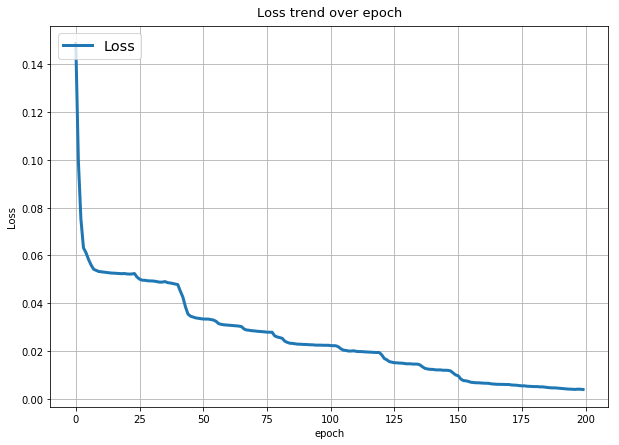

In [61]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(hist.history['loss'], linewidth=3 )
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Loss'], loc='upper left', fontsize='x-large')
plt.title('Loss trend over epoch',pad=10, fontdict={'fontsize':13})
plt.show()

In [25]:
model.fit(x, y.reshape(-1,90), epochs=100, batch_size=16)

Epoch 1/100
95/95 [==============================] - 3s 30ms/step - loss: 0.0357
Epoch 2/100
95/95 [==============================] - 3s 33ms/step - loss: 0.0335
Epoch 3/100
95/95 [==============================] - 3s 32ms/step - loss: 0.0327
Epoch 4/100
95/95 [==============================] - 3s 32ms/step - loss: 0.0300
Epoch 5/100
95/95 [==============================] - 3s 32ms/step - loss: 0.0285
Epoch 6/100
95/95 [==============================] - 3s 34ms/step - loss: 0.0278
Epoch 7/100
95/95 [==============================] - 3s 34ms/step - loss: 0.0275
Epoch 8/100
95/95 [==============================] - 3s 33ms/step - loss: 0.0271
Epoch 9/100
95/95 [==============================] - 3s 33ms/step - loss: 0.0266
Epoch 10/100
95/95 [==============================] - 3s 33ms/step - loss: 0.0264
Epoch 11/100
95/95 [==============================] - 3s 33ms/step - loss: 0.0263
Epoch 12/100
95/95 [==============================] - 3s 33ms/step - loss: 0.0260
Epoch 13/100
95/95 [=====

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 90, 512)           789504    
_________________________________________________________________
activation_8 (Activation)    (None, 90, 512)           0         
_________________________________________________________________
gru_9 (GRU)                  (None, 512)               1574400   
_________________________________________________________________
activation_9 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 90)                46170     
Total params: 2,410,074
Trainable params: 2,410,074
Non-trainable params: 0
_________________________________________________________________


# 5. 검증 
 - 특정시점에서 실제값과 예측값을 대조해본다

Text(0.5, 1.0, 'Validation at specific time')

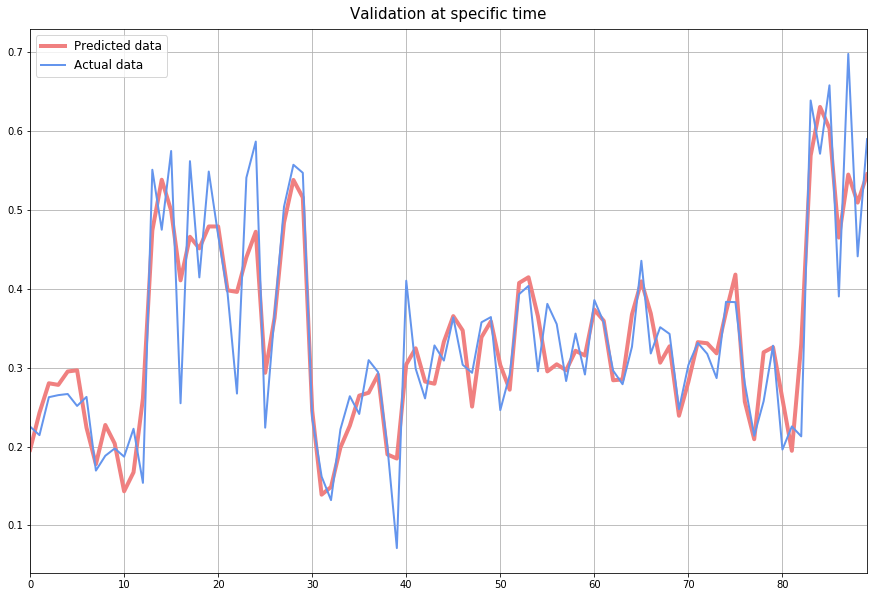

In [62]:
# 학습 결과 실제 수치와 예측수치 비교 
idx = 12   # T= 12 시점
res = model.predict(x[idx].reshape((1,n_steps,1)))
y_ = np.ndarray.flatten(y[idx])

plt.figure(figsize=(15,10))

pd.Series(res[0]).plot(color ='lightcoral', label='Predicted data', linewidth=4) #빨간선은 예측 수치(정규화된 상태)
pd.Series(y_).plot(color = 'cornflowerblue', label='Actual data', linewidth=2)   #파란선은 실제 수치(정규화된 상태)
plt.legend(fontsize='large')
plt.grid()
plt.title('Validation at specific time', pad=10, fontdict={'fontsize':15})

In [38]:
#predict 예측 결과 저장
yhat = model.predict(dataset_scaled[-n_steps:].reshape((-1,n_steps,1)))

In [39]:
# 정규화된 데이터를 실제 값으로 반환
def Minmax_restore(arr, min_v, max_v):
    mul = max_v - min_v
    add = min_v
    return arr * mul + add

In [1]:
# 실제 수치와 비교 하기위해 정규화 데이터를 원데이터로 scaling
yhat_restore = Minmax_restore(yhat, 45, 56.71726911)
data_restore = Minmax_restore(dataset_scaled,45, 56.71726911)

NameError: name 'Minmax_restore' is not defined

In [41]:
# 결과값 확인
yhat_restore

array([[50.622135, 49.168682, 50.451767, 51.42445 , 53.94972 , 50.813732,
        49.263313, 49.936108, 48.059547, 50.27603 , 49.47013 , 50.627228,
        51.36683 , 51.162666, 53.374474, 51.333897, 51.819305, 50.40939 ,
        51.534214, 49.39969 , 50.98889 , 51.804962, 51.020554, 50.23887 ,
        50.581547, 50.695747, 52.658596, 52.474667, 56.164837, 55.145714,
        52.368237, 56.76435 , 52.92789 , 53.79606 , 52.03302 , 50.13851 ,
        50.022987, 54.550056, 51.17503 , 50.26997 , 52.90905 , 51.84473 ,
        50.407784, 49.793846, 51.6766  , 49.122562, 50.0038  , 52.127907,
        51.911457, 50.20586 , 51.403473, 53.97693 , 51.980133, 51.31652 ,
        51.38885 , 49.541862, 51.519817, 52.047493, 51.749424, 55.103954,
        54.81776 , 54.082565, 51.8787  , 53.278847, 55.78345 , 53.589348,
        53.766933, 53.341225, 56.329193, 57.148453, 53.692955, 49.971535,
        51.267185, 50.888775, 53.371387, 52.59666 , 50.590324, 50.22838 ,
        47.99937 , 52.741707, 50.22196

# 6. 예측 시각화

Text(0.5, 1.0, '30days prediction model')

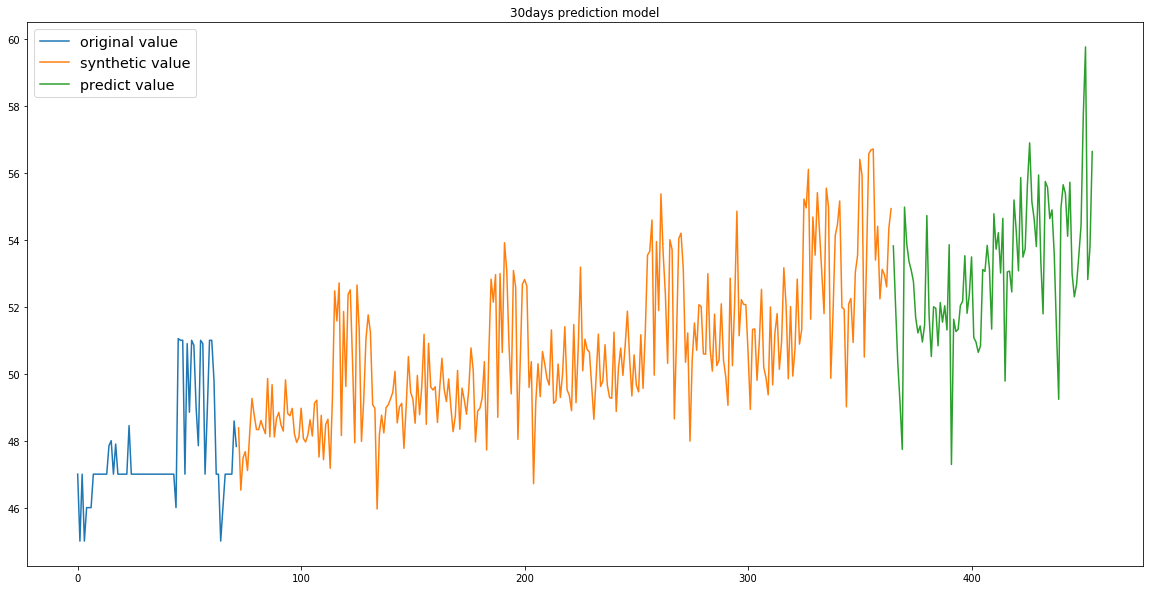

In [20]:
# 30 days graph
plt.figure(figsize=(20,10))
pd.Series(data_restore[:72].reshape((-1,)), index=list(range(data_restore[:72].shape[0]))).plot(label='original value')
pd.Series(data_restore[72:].reshape((-1,)), index= list(range(72, 72+data_restore[72:].shape[0]))).plot(label='synthetic value')
pd.Series(yhat_restore.reshape((-1,)), index= list(range(dataset_scaled.shape[0], dataset_scaled.shape[0]+yhat.flatten().shape[0] ))).plot(label='predict value')
plt.legend(fontsize='x-large')
plt.title('30days prediction model')

Text(0.5, 1.0, '60days prediction model')

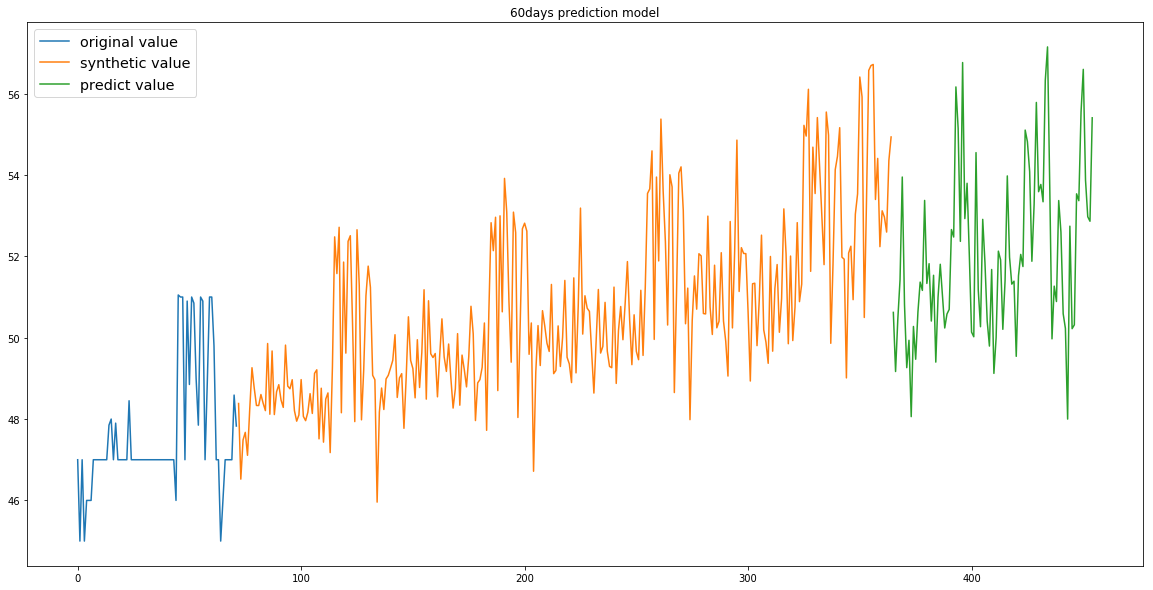

In [42]:
# 90days 
plt.figure(figsize=(20,10))
pd.Series(data_restore[:72].reshape((-1,)), index=list(range(data_restore[:72].shape[0]))).plot(label='original value')
pd.Series(data_restore[72:].reshape((-1,)), index= list(range(72, 72+data_restore[72:].shape[0]))).plot(label='synthetic value')
pd.Series(yhat_restore.reshape((-1,)), index= list(range(dataset_scaled.shape[0], dataset_scaled.shape[0]+yhat.flatten().shape[0] ))).plot(label='predict value')
plt.legend(fontsize='x-large')
plt.title('60days prediction model')

Text(0.5, 1.0, '180days prediction model')

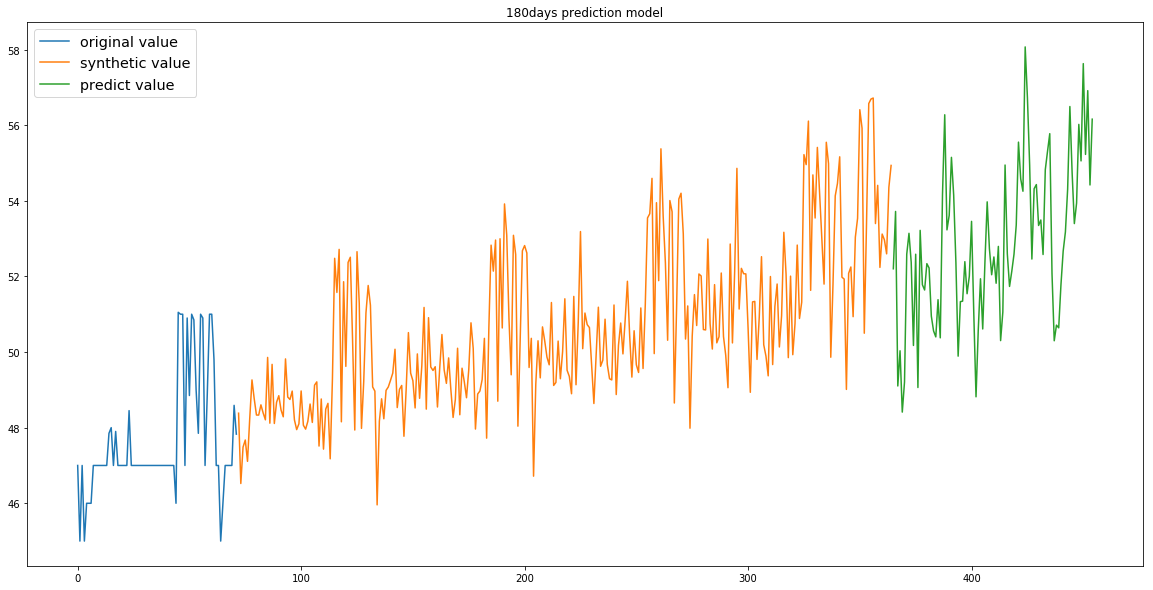

In [32]:
# 180days 
plt.figure(figsize=(20,10))
pd.Series(data_restore[:72].reshape((-1,)), index=list(range(data_restore[:72].shape[0]))).plot(label='original value')
pd.Series(data_restore[72:].reshape((-1,)), index= list(range(72, 72+data_restore[72:].shape[0]))).plot(label='synthetic value')
pd.Series(yhat_restore.reshape((-1,)), index= list(range(dataset_scaled.shape[0], dataset_scaled.shape[0]+yhat.flatten().shape[0] ))).plot(label='predict value')
plt.legend(fontsize='x-large')
plt.title('180days prediction model')

# 7. 학습모델 저장

In [43]:
# model.save('./models/2GRU1024_nonStateful_30in90out.h5')
model.save('./models/2GRU1024_nonStateful_90in90out.h5')
# model.save('./models/2GRU1024_nonStateful_180in90out.h5')

In [59]:
model = models.load_model('./models/2GRU1024_nonStateful_30days.h5')

-----

-  *아래는 다양한 학습모델 시도*

### stateful GRU

In [19]:

model = Sequential()
model.add(GRU(1024, batch_input_shape=(x.shape[0], x.shape[1], x.shape[2]), return_sequences=True, stateful=True))
model.add(Activation("tanh"))
model.add(GRU(1024, return_sequences=True))
model.add(Activation("tanh"))
model.add(GRU(512, return_sequences=False))
model.add(Activation("tanh"))
#model.add(Dropout(0.5))
# model.add(TimeDistributed(Dense(n_steps)))
model.add(Dense(n_steps))
model.add(Activation("linear"))

# optimizer = keras.optimizers.RMSprop(lr=0.002)
optimizer = keras.optimizers.Nadam(lr=0.002)
model.compile(loss='mse', optimizer=optimizer)

for i in range(200):
    model.fit(x, y.reshape((-1, n_steps)), batch_size=1,  epochs=1, shuffle=False)
    model.reset_states()

W0926 02:57:53.390619 139702538901312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/1


InvalidArgumentError: Matrix size-incompatible: In[0]: [1,1], In[1]: [290,3072]
	 [[{{node training/Nadam/gradients/gru_13/while/MatMul_grad/MatMul_1}}]]

In [37]:
#laod model
model = models.load_model('./models/2GRU1024_nonStateful_30days.h5')

### ARIMA

In [28]:
data = pd.DataFrame(index = orig_df['MESR_DAY'].get_values(), data = orig_df['PD_MAX'].get_values())

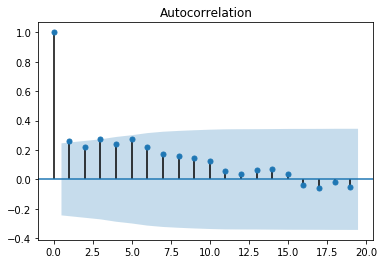

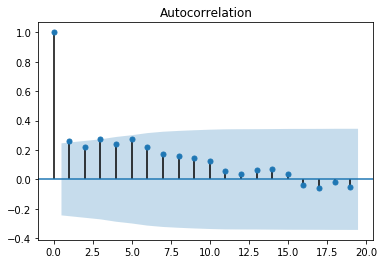

In [29]:
plot_acf(data)

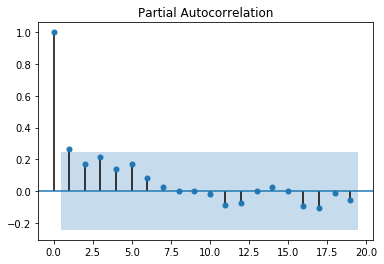

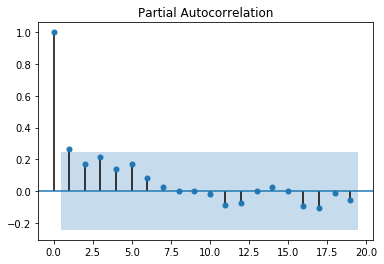

In [30]:
plot_pacf(data)

### stateful LSTM

In [11]:
look_back=30
dataset = seq2dataset(dataset_scaled, look_back=look_back)

In [22]:
x = dataset[:,:look_back]
y = dataset[:, look_back:]

In [11]:
x = x.reshape((-1,look_back,1))

In [12]:
print(x.shape)
print(y.shape)

(290, 30, 1)
(290, 30, 1)


In [26]:
##architecture
class Customhistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss=[]
        self.val_loss=[]
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
                   
model = Sequential()
for i in range(1):
    model.add(LSTM(64, batch_input_shape=(1, x.shape[1], x.shape[2]), stateful=True, return_sequences=False ))
#     model.add(BatchNormalization())
    model.add(Dropout(0.2))
# model.add(LSTM(64, stateful=True, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(32))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dense(4))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Dense(look_back, activation='relu'))

#train
model.compile(loss = 'mse', optimizer='adam')
custom_hist = Customhistory()
custom_hist.init()

for i in range(500):
    model.fit(x, y.reshape((-1,look_back)), epochs=1, batch_size=1, shuffle=False)
    model.reset_states()

Epoch 1/1
290/290 [==============================] - 9s 33ms/step - loss: 0.0377
Epoch 1/1
290/290 [==============================] - 9s 31ms/step - loss: 0.0273
Epoch 1/1
290/290 [==============================] - 9s 31ms/step - loss: 0.0263
Epoch 1/1
290/290 [==============================] - 9s 30ms/step - loss: 0.0262
Epoch 1/1
290/290 [==============================] - 9s 32ms/step - loss: 0.0258
Epoch 1/1
290/290 [==============================] - 9s 31ms/step - loss: 0.0257
Epoch 1/1
290/290 [==============================] - 9s 32ms/step - loss: 0.0261
Epoch 1/1
290/290 [==============================] - 9s 31ms/step - loss: 0.0256
Epoch 1/1
290/290 [==============================] - 9s 31ms/step - loss: 0.0253
Epoch 1/1
290/290 [==============================] - 9s 31ms/step - loss: 0.0254
Epoch 1/1
290/290 [==============================] - 9s 31ms/step - loss: 0.0257
Epoch 1/1
290/290 [==============================] - 9s 32ms/step - loss: 0.0259
Epoch 1/1
290/290 [=========

KeyboardInterrupt: 

In [113]:
for i in range(300):
    model.fit(x, y.reshape((-1,look_back)), epochs=1, batch_size=1, shuffle=False)
    model.reset_states()

Epoch 1/1
290/290 [==============================] - 23s 78ms/step - loss: 0.0199
Epoch 1/1
290/290 [==============================] - 23s 78ms/step - loss: 0.0201
Epoch 1/1
290/290 [==============================] - 24s 82ms/step - loss: 0.0199
Epoch 1/1
290/290 [==============================] - 23s 78ms/step - loss: 0.0199
Epoch 1/1
290/290 [==============================] - 22s 77ms/step - loss: 0.0198
Epoch 1/1
290/290 [==============================] - 23s 78ms/step - loss: 0.0198
Epoch 1/1
290/290 [==============================] - 23s 79ms/step - loss: 0.0199
Epoch 1/1
290/290 [==============================] - 22s 77ms/step - loss: 0.0199
Epoch 1/1
290/290 [==============================] - 23s 78ms/step - loss: 0.0197
Epoch 1/1
290/290 [==============================] - 23s 78ms/step - loss: 0.0197
Epoch 1/1
290/290 [==============================] - 22s 77ms/step - loss: 0.0198
Epoch 1/1
290/290 [==============================] - 22s 77ms/step - loss: 0.0198
Epoch 1/1
290/29

KeyboardInterrupt: 

In [62]:
# yhat = []
# for i in range(x.shape[0]):
#     res = model.predict(np.asarray(x[i]).reshape((1,look_back,1)))
#     yhat.append(res[0][0])

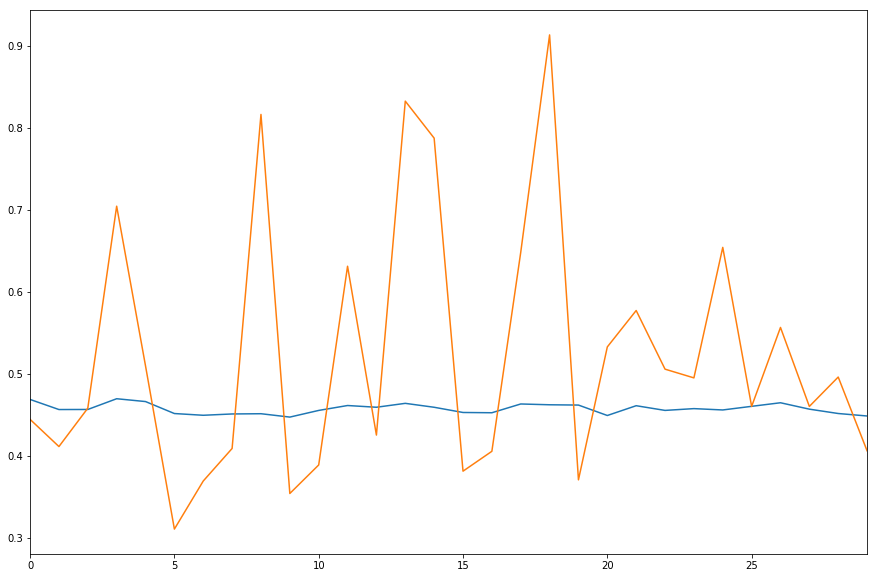

In [138]:
idx = 289
res = model.predict(x[idx].reshape((1,30,1)))
y_ = np.ndarray.flatten(y[idx])

plt.figure(figsize=(15,10))
pd.Series(res[0]).plot()
pd.Series(y_).plot()

In [114]:
model.save('./models/2LSTM64_lb30_stateful.h5')
model.save_weights('./models/2LSTM64_lb30_stateful_weights.h5')

### non-stateful LSTM

In [146]:
x = dataset[:, : look_back]
y = dataset[:, look_back:]

In [13]:
## non stateful
class Customhistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss=[]
        self.val_loss=[]
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
                   
model = Sequential()
# for i in range(1):
model.add(LSTM(64, input_shape=( x.shape[1], x.shape[2]), stateful=False, return_sequences=True ))
model.add(Dropout(0.3))
model.add(LSTM(64, stateful=False, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dense(4))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Dense(look_back, activation='relu'))

model.compile(loss = 'mse', optimizer='adadelta')
#train

custom_hist = Customhistory()
custom_hist.init()

model.fit(x, y.reshape(-1,look_back), epochs=200, batch_size=16, shuffle=False)

W0926 01:22:01.334260 140214659716928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/200
290/290 [==============================] - 2s 8ms/step - loss: 0.1437
Epoch 2/200
290/290 [==============================] - 1s 4ms/step - loss: 0.1207
Epoch 3/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0981
Epoch 4/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0725
Epoch 5/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0586
Epoch 6/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0503
Epoch 7/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0439
Epoch 8/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0438
Epoch 9/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0397
Epoch 10/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0436
Epoch 11/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0421
Epoch 12/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0393
Epoch 13/200


290/290 [==============================] - 1s 4ms/step - loss: 0.0267
Epoch 197/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0271
Epoch 198/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0286
Epoch 199/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0276
Epoch 200/200
290/290 [==============================] - 1s 4ms/step - loss: 0.0280


In [14]:
# model.compile(loss = 'mse', optimizer='adadelta')
model.fit(x, y.reshape(-1,look_back), epochs=200, batch_size=32, shuffle=True)

Epoch 1/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0277
Epoch 2/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0252
Epoch 3/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0255
Epoch 4/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0250
Epoch 5/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0247
Epoch 6/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0254
Epoch 7/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0255
Epoch 8/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0251
Epoch 9/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0252
Epoch 10/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0250
Epoch 11/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0249
Epoch 12/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0250
Epoch 13/200


290/290 [==============================] - 1s 2ms/step - loss: 0.0243
Epoch 197/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0242
Epoch 198/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0244
Epoch 199/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0243
Epoch 200/200
290/290 [==============================] - 1s 2ms/step - loss: 0.0248


In [155]:
yhat = []
for i in range(x.shape[0]-5):
    res = model.predict(np.asarray(x[i]).reshape((1,5,1)))
#     print(res[0][0])
    yhat.append(res[0][0])

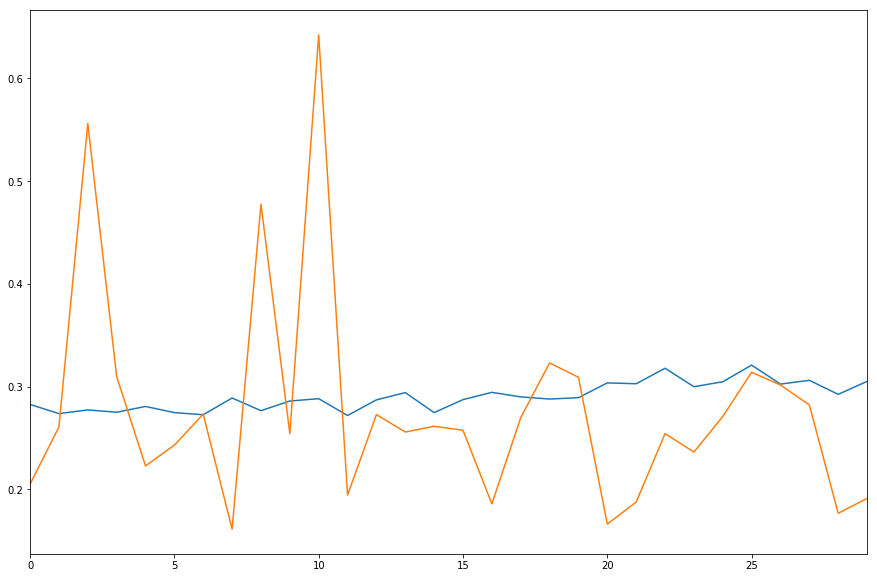

In [124]:
idx = 50
res = model.predict(x[idx].reshape((1,30,1)))
y_ = np.ndarray.flatten(y[idx])

plt.figure(figsize=(15,10))
pd.Series(res[0]).plot()
pd.Series(y_).plot()

2019-09-17 00:00:00 [[0.90023226]]
2019-09-18 00:00:00 [[0.92747605]]
2019-09-19 00:00:00 [[0.93559635]]
2019-09-20 00:00:00 [[0.92341113]]
2019-09-21 00:00:00 [[0.9105461]]
2019-09-22 00:00:00 [[0.9080774]]
2019-09-23 00:00:00 [[0.91088516]]
2019-09-24 00:00:00 [[0.9082302]]
2019-09-25 00:00:00 [[0.90363044]]
2019-09-26 00:00:00 [[0.90072304]]
2019-09-27 00:00:00 [[0.89964753]]
2019-09-28 00:00:00 [[0.89860433]]
2019-09-29 00:00:00 [[0.89671445]]
2019-09-30 00:00:00 [[0.89498866]]
2019-10-01 00:00:00 [[0.89379805]]
2019-10-02 00:00:00 [[0.8928678]]
2019-10-03 00:00:00 [[0.89190114]]
2019-10-04 00:00:00 [[0.89091825]]
2019-10-05 00:00:00 [[0.8900903]]
2019-10-06 00:00:00 [[0.8894056]]
2019-10-07 00:00:00 [[0.88878596]]
2019-10-08 00:00:00 [[0.8882009]]
2019-10-09 00:00:00 [[0.8876706]]
2019-10-10 00:00:00 [[0.8872099]]
2019-10-11 00:00:00 [[0.886802]]
2019-10-12 00:00:00 [[0.88643146]]
2019-10-13 00:00:00 [[0.88609546]]
2019-10-14 00:00:00 [[0.88579553]]
2019-10-15 00:00:00 [[0.8855292

2020-05-26 00:00:00 [[0.8832145]]
2020-05-27 00:00:00 [[0.8832145]]
2020-05-28 00:00:00 [[0.8832145]]
2020-05-29 00:00:00 [[0.8832145]]
2020-05-30 00:00:00 [[0.8832145]]
2020-05-31 00:00:00 [[0.8832145]]
2020-06-01 00:00:00 [[0.8832145]]
2020-06-02 00:00:00 [[0.8832145]]
2020-06-03 00:00:00 [[0.8832145]]
2020-06-04 00:00:00 [[0.8832145]]
2020-06-05 00:00:00 [[0.8832145]]
2020-06-06 00:00:00 [[0.8832145]]
2020-06-07 00:00:00 [[0.8832145]]
2020-06-08 00:00:00 [[0.8832145]]
2020-06-09 00:00:00 [[0.8832145]]
2020-06-10 00:00:00 [[0.8832145]]
2020-06-11 00:00:00 [[0.8832145]]
2020-06-12 00:00:00 [[0.8832145]]
2020-06-13 00:00:00 [[0.8832145]]
2020-06-14 00:00:00 [[0.8832145]]
2020-06-15 00:00:00 [[0.8832145]]
2020-06-16 00:00:00 [[0.8832145]]
2020-06-17 00:00:00 [[0.8832145]]
2020-06-18 00:00:00 [[0.8832145]]
2020-06-19 00:00:00 [[0.8832145]]
2020-06-20 00:00:00 [[0.8832145]]
2020-06-21 00:00:00 [[0.8832145]]
2020-06-22 00:00:00 [[0.8832145]]
2020-06-23 00:00:00 [[0.8832145]]
2020-06-24 00:

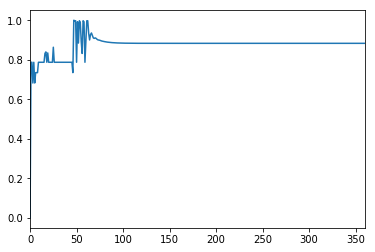

In [157]:
pd_append = pd_s
for date in pd.date_range('2019-09-17','2020-07-09'):
    res = model.predict(np.asarray(pd_append[-5:]).reshape((1,5,1)))
    print(date, res)
    pd_append = np.concatenate([pd_append,res])
pd.Series(pd_append.reshape((-1))).plot()

### CNN-LSTM

In [15]:
n_steps = 30
dataset = seq2dataset(dataset_scaled, look_back=n_steps)

x = dataset[:,:n_steps]
y = dataset[:, n_steps:]

In [16]:
n_features = 1
n_steps_ = 10
n_freq = 3
x = x.reshape((x.shape[0], n_freq,  n_steps_, n_features))

In [25]:
#architecture
model = Sequential()
model.add(TimeDistributed(Conv1D(filters = 64, kernel_size=1, activation='relu'), input_shape = (None, n_steps_, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences = True, activation='relu'))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences = False))
model.add(BatchNormalization())
model.add(Dense(n_steps))

model.compile(optimizer = 'adam', loss='mse')

model.fit(x,y.reshape((-1, n_steps)), epochs=200, shuffle=False)

NameError: name 'n_features' is not defined

In [30]:
model.predict(x[2].reshape((1,3,10,1)))

array([[0.22495721, 0.24093051, 0.22368929, 0.15664047, 0.18017949,
        0.21574882, 0.2240766 , 0.19957894, 0.23007771, 0.21554986,
        0.22309986, 0.24109943, 0.23774868, 0.25527436, 0.2692256 ,
        0.2768775 , 0.2663759 , 0.28486264, 0.25729132, 0.2369817 ,
        0.26910716, 0.28577167, 0.2737463 , 0.2583996 , 0.24771784,
        0.23867498, 0.26120046, 0.25042635, 0.23329292, 0.23352803]],
      dtype=float32)